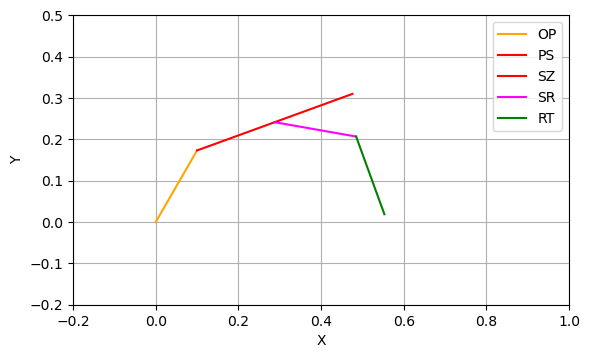

C:\Users\okseb\AppData\Local\Temp\ipykernel_2712\3486767879.py:120: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  salida = fsolve(solver, z0)
C:\Users\okseb\AppData\Local\Temp\ipykernel_2712\3486767879.py:120: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  salida = fsolve(solver, z0)


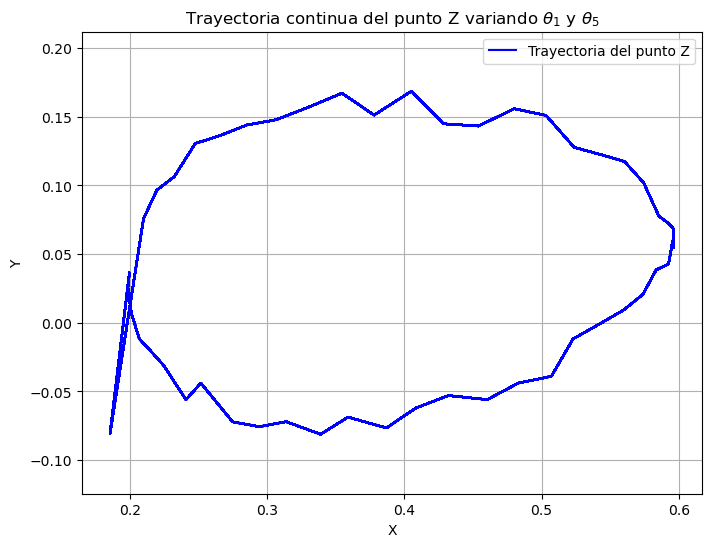

In [86]:
from sympy import symbols, Function, diff
from sympy import symbols, pi
from sympy.physics.mechanics import dynamicsymbols, ReferenceFrame
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
import sympy as sp
from sympy import symbols, flatten, Matrix
from sympy.physics.mechanics import dynamicsymbols
from sympy import symbols, Function, diff, Eq, linear_eq_to_matrix

# Definición de variables simbólicas
theta1, theta2, theta3, theta4, theta5 = dynamicsymbols('theta1 theta2 theta3 theta4 theta5')
OP, PS, SR, RT, RZ, d1, d2 = symbols('OP PS SR RT RZ d1 d2')

# Parámetros del mecanismo
params = {OP: 0.2, PS: 0.2, SR: 0.2, RT: 0.2, d1: 0.10, d2: 0.70}

# Marcos de referencia
N = ReferenceFrame('N')
A = N.orientnew('A', 'Axis', (theta1, N.z))
B = A.orientnew('B', 'Axis', (-theta2, N.z))
C = B.orientnew('C', 'Axis', (-theta3, N.z))
D = C.orientnew('D', 'Axis', (-theta4, N.z))


# Vectores de posición
r1 = OP * A.x
r2 = PS * B.x
r3 = SR * C.x
r4 = RT * D.x
r5 = -d2 * N.x - d1 * N.y

# Ecuación de restricción para el bucle de posición
r_pos = r1 + r2 + r3 + r4 + r5 
r_params = r_pos.subs(params)

# Ecuación de restricción para los ángulos
eq_theta5 = theta1 - theta2 - theta3 - theta4 + np.deg2rad(180)
  # Usamos pi en lugar de np.deg2rad(180)

# Función para evaluar las ecuaciones de restricción
r_fun = sp.lambdify([theta1, theta2, theta3, theta4, theta5], [r_params.dot(N.x), r_params.dot(N.y), eq_theta5])

# Solución para el mecanismo (dinámica directa)
theta1_val = np.deg2rad(45)  # Valor de ejemplo para theta1
theta5_val = np.deg2rad(20)  # Valor de ejemplo para theta5

# Función para resolver las ecuaciones de restricción
solver = lambda z: r_fun(theta1_val, z[0], z[1], z[2], theta5_val)

# Valores iniciales para theta2, theta3, theta4
z0 = [np.deg2rad(-60), np.deg2rad(-10), np.deg2rad(-20)]

# Resolver las ecuaciones de restricción
salida = fsolve(solver, z0, full_output=True)
valores_conjunto = [theta1_val, salida[0][0], salida[0][1], salida[0][2], theta5_val]


# Función para plotear el mecanismo
puntos = {'O': 0*N.x, 'P': r1, 'S': r1 + r2, 'Z':r1+r2+r2, 'R': r1 + r2 + r3, 'T': r1 + r2 + r3 + r4}
puntos_fun = {
    d: sp.lambdify(
        [theta1, theta2, theta3, theta4, theta5],
        [v.dot(N.x).subs(params), v.dot(N.y).subs(params)]
    )
    for d, v in puntos.items()
}

# Función para graficar el mecanismo
def plotear(valores_conjunto, ax=None):
    O = puntos_fun['O'](*valores_conjunto)
    P = puntos_fun['P'](*valores_conjunto)
    S = puntos_fun['S'](*valores_conjunto)  # Corregido: 'S' en lugar de 'Q'
    R = puntos_fun['R'](*valores_conjunto)
    T = puntos_fun['T'](*valores_conjunto)
    Z = puntos_fun['Z'](*valores_conjunto)

    if ax is None:
        ax = plt.figure().add_subplot(111)

    # Dibujar las líneas del mecanismo
    ax.plot([O[0], P[0]], [O[1], P[1]], 'orange', label='OP')
    ax.plot([P[0], S[0]], [P[1], S[1]], 'red', label='PS')
    ax.plot([S[0], Z[0]], [S[1], Z[1]], 'red', label='SZ')
    ax.plot([S[0], R[0]], [S[1], R[1]], 'magenta', label='SR')
    ax.plot([R[0], T[0]], [R[1], T[1]], 'green', label='RT')
   

    # Configuración del gráfico
    ax.set_aspect('equal')
    ax.set_xlim(-0.2, 1.0)
    ax.set_ylim(-0.2, 0.5)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.legend()
    ax.grid(True)
    plt.show()

plotear([np.deg2rad(60),np.deg2rad(40),np.deg2rad(30),np.deg2rad(60),np.deg2rad(70)])

# Generar un rango de valores para theta1 y theta5 para observar la trayectoria del punto Z
theta1_range = np.linspace(0, 2 * np.pi, 50)
theta5_range = np.linspace(0, 2 * np.pi, 50)

# Crear una malla de valores para theta1 y theta5
theta1_grid, theta5_grid = np.meshgrid(theta1_range, theta5_range)

# Almacenar las posiciones de Z
x_Z = np.zeros_like(theta1_grid)
y_Z = np.zeros_like(theta5_grid)

# Resolver para cada combinación de theta1 y theta5
for i in range(theta1_grid.shape[0]):
    for j in range(theta1_grid.shape[1]):
        theta1_val = theta1_grid[i, j]
        theta5_val = theta5_grid[i, j]
        solver = lambda z: r_fun(theta1_val, z[0], z[1], z[2], theta5_val)
        z0 = [np.deg2rad(60), np.deg2rad(-10), np.deg2rad(-20)]
        salida = fsolve(solver, z0)
        valores_conjunto = [theta1_val, salida[0], salida[1], salida[2], theta5_val]
        Z = puntos_fun['Z'](*valores_conjunto)
        x_Z[i, j], y_Z[i, j] = Z

plt.figure(figsize=(8, 6))
plt.plot(x_Z.flatten(), y_Z.flatten(), '-', color='blue', label='Trayectoria del punto Z')  # Línea continua
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Trayectoria continua del punto Z variando $\\theta_1$ y $\\theta_5$')
plt.grid(True)
plt.axis('equal')
plt.legend()
plt.show()

C:\Users\okseb\AppData\Local\Temp\ipykernel_2712\1106061404.py:8: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  salida = fsolve(solver, z0)
C:\Users\okseb\AppData\Local\Temp\ipykernel_2712\1106061404.py:8: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  salida = fsolve(solver, z0)


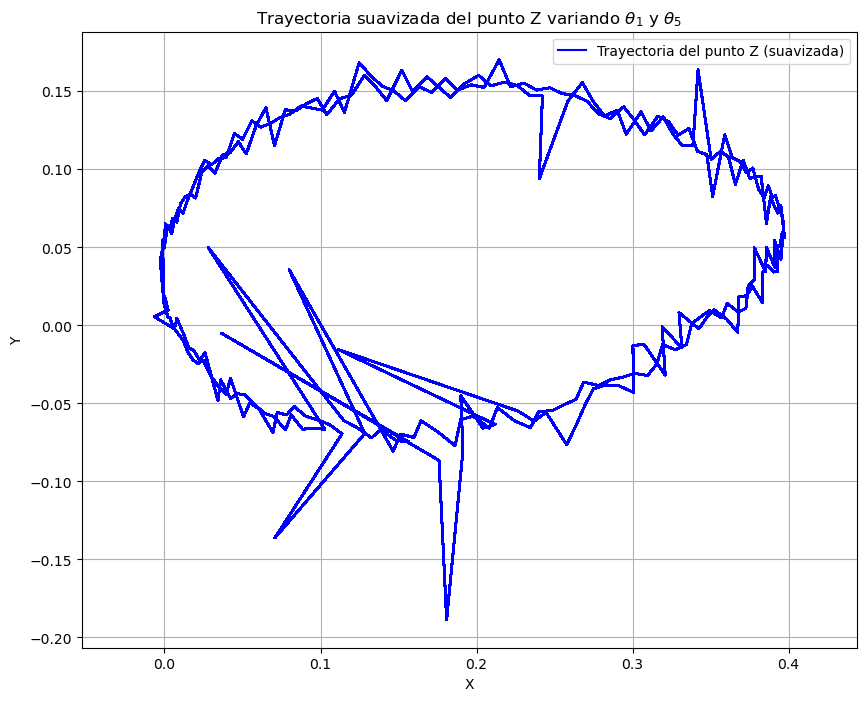

In [85]:
# Resolver para cada combinación de theta1 y theta5
for i in range(theta1_grid.shape[0]):
    for j in range(theta1_grid.shape[1]):
        theta1_val = theta1_grid[i, j]
        theta5_val = theta5_grid[i, j]
        solver = lambda z: r_fun(theta1_val, z[0], z[1], z[2], theta5_val)
        z0 = [np.deg2rad(60), np.deg2rad(-10), np.deg2rad(-20)]
        salida = fsolve(solver, z0)
        valores_conjunto = [theta1_val, salida[0], salida[1], salida[2], theta5_val]
        Z = puntos_fun['Z'](*valores_conjunto)
        x_Z[i, j], y_Z[i, j] = Z

# Graficar la trayectoria con mayor suavidad
plt.figure(figsize=(10, 8))
plt.plot(x_Z.flatten(), y_Z.flatten(), '-', color='blue', label='Trayectoria del punto Z (suavizada)')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Trayectoria suavizada del punto Z variando $\\theta_1$ y $\\theta_5$')
plt.grid(True)
plt.axis('equal')
plt.legend()
plt.show()
